Spark session created successfully!

=== DATA LOADING & TRANSFORMATION ===
✓ Total rows loaded: 55,500
✓ Data transformation completed. Sample data:
+-----------------+--------------------+---+---------+---------------------+
|Date of Admission|Admission_Year_Month|Age|Age Group|Length of Stay (Days)|
+-----------------+--------------------+---+---------+---------------------+
|       2024-01-31|             2024-01| 30|    21-40|                    2|
|       2019-08-20|             2019-08| 62|    61-80|                    6|
|       2022-09-22|             2022-09| 76|    61-80|                   15|
|       2020-11-18|             2020-11| 28|    21-40|                   30|
|       2022-09-19|             2022-09| 43|    41-60|                   20|
+-----------------+--------------------+---+---------+---------------------+
only showing top 5 rows


=== 1. TEMPORAL ANALYSIS ===
--- Monthly Patient Volume and Avg. Stay ---
+--------------------+----------------+------------------+

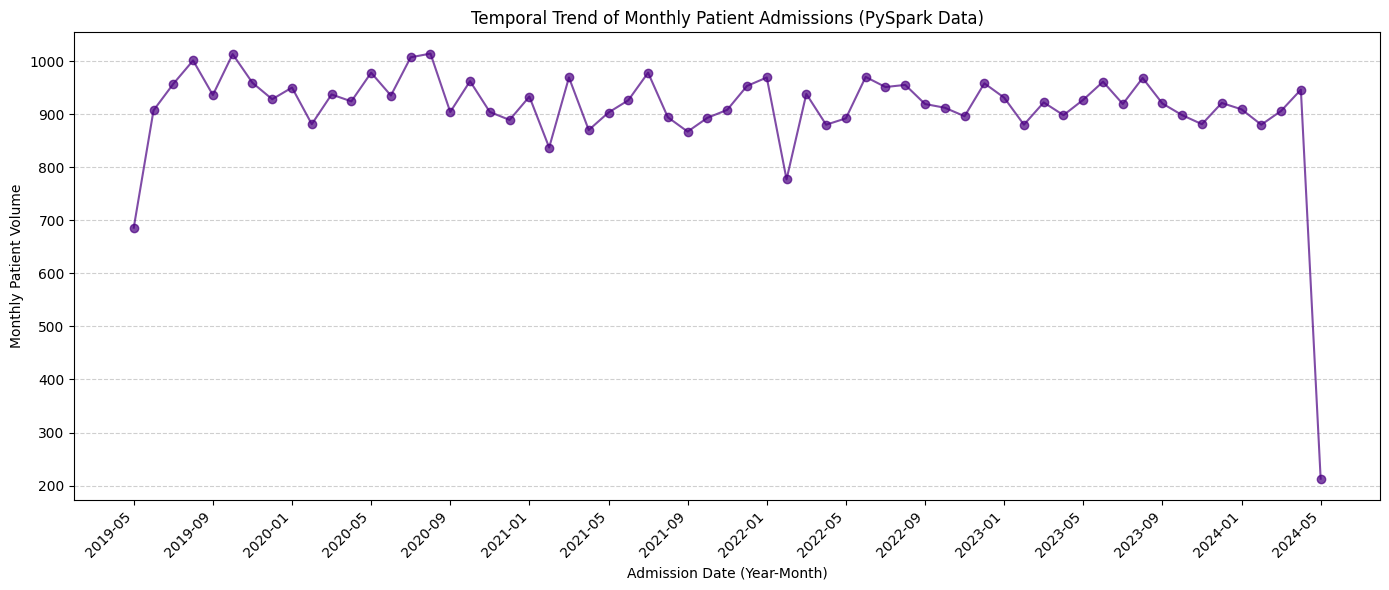

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, initcap, trim, datediff, to_date, 
    count, avg, ceil, when, concat, lit, date_format
)
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== 1. SPARK SESSION SETUP =====
def create_spark_session():
    """Create and configure Spark session"""
    spark = SparkSession.builder \
        .appName("HealthcareAnalysis") \
        .master("local[*]") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    print("Spark session created successfully!")
    return spark

# ===== 2. DATA LOADING & TRANSFORMATION =====
def transform_data(spark, file_path="healthcare_dataset.csv"):
    """Load, clean, and transform the healthcare data"""
    print("\n=== DATA LOADING & TRANSFORMATION ===")
    
    # Load data with schema inference
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print(f"✓ Total rows loaded: {df.count():,}")
    
    # Standardize text columns (Title Case and trim whitespace)
    text_cols = ['Name', 'Gender', 'Medical Condition', 'Doctor', 'Hospital', 
                 'Insurance Provider', 'Admission Type', 'Medication', 
                 'Test Results', 'Blood Type']
    
    for c in text_cols:
        df = df.withColumn(c, initcap(trim(col(c))))
        
    # Convert date columns to DateType
    df = df.withColumn(
        "Date of Admission", to_date(col("Date of Admission"), "yyyy-MM-dd")
    ).withColumn(
        "Discharge Date", to_date(col("Discharge Date"), "yyyy-MM-dd")
    )
    
    # Feature Engineering: Calculate Length of Stay (in days)
    df = df.withColumn(
        "Length of Stay (Days)", datediff(col("Discharge Date"), col("Date of Admission"))
    )

    # Feature Engineering: Create Temporal Features (Year-Month)
    df = df.withColumn(
        "Admission_Year_Month", date_format(col("Date of Admission"), "yyyy-MM")
    )

    # Feature Engineering: Create Age Groups (for Bivariate Analysis)
    df = df.withColumn("Age Group", 
        when((col("Age") >= 13) & (col("Age") <= 20), "13-20")
        .when((col("Age") >= 21) & (col("Age") <= 40), "21-40")
        .when((col("Age") >= 41) & (col("Age") <= 60), "41-60")
        .when((col("Age") >= 61) & (col("Age") <= 80), "61-80")
        .otherwise("81+")
    )
    
    print("✓ Data transformation completed. Sample data:")
    df.select("Date of Admission", "Admission_Year_Month", "Age", "Age Group", "Length of Stay (Days)").show(5)
    
    return df

# ===== 3. TEMPORAL ANALYSIS: Patient Volume & Stay =====
def temporal_analysis(df):
    """Analyze patient volume and stay trends over time"""
    print("\n=== 1. TEMPORAL ANALYSIS ===")
    
    temporal_df = df.groupBy("Admission_Year_Month").agg(
        count(col("Name")).alias("Monthly_Patients"),
        avg(col("Length of Stay (Days)")).alias("Avg_Length_of_Stay")
    ).orderBy("Admission_Year_Month")

    print("--- Monthly Patient Volume and Avg. Stay ---")
    temporal_df.show(5)

    # Convert to Pandas for visualization
    temporal_pd = temporal_df.toPandas()
    
    plt.figure(figsize=(14, 6))
    plt.plot(temporal_pd['Admission_Year_Month'], temporal_pd['Monthly_Patients'], marker='o', linestyle='-', color='indigo', alpha=0.7)
    n = 4
    plt.xticks(temporal_pd['Admission_Year_Month'][::n], rotation=45, ha='right')
    plt.xlabel('Admission Date (Year-Month)')
    plt.ylabel('Monthly Patient Volume')
    plt.title('Temporal Trend of Monthly Patient Admissions (PySpark Data)')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('pyspark_monthly_patient_volume.png')
    print("✓ Visualization saved: pyspark_monthly_patient_volume.png")
    
    return temporal_df

# ===== 4. CATEGORICAL ANALYSIS: Distribution =====
def categorical_analysis(df):
    """Analyze distribution of Medical Condition and Gender"""
    print("\n=== 2. CATEGORICAL ANALYSIS ===")
    
    total_patients = df.count()
    
    # A. Medical Condition Distribution
    condition_dist = df.groupBy("Medical Condition").agg(
        count("*").alias("Total Patients"),
    ).withColumn(
        "Share (%)", round(col("Total Patients") / total_patients * 100, 1)
    ).orderBy(col("Total Patients").desc())

    print("--- Distribution by Medical Condition ---")
    condition_dist.show()

    # B. Gender Distribution
    gender_dist = df.groupBy("Gender").agg(
        count("*").alias("Total Patients")
    ).withColumn(
        "Share (%)", round(col("Total Patients") / total_patients * 100, 1)
    ).orderBy(col("Total Patients").desc())

    print("--- Distribution by Gender ---")
    gender_dist.show()
    
    return condition_dist, gender_dist

# ===== 5. BIVARIATE ANALYSIS: Billing vs. Age Group =====
def bivariate_analysis(df):
    """Analyze average billing amount by Age Group"""
    print("\n=== 3. BIVARIATE ANALYSIS: BILLING VS. AGE ===")
    
    billing_by_age = df.groupBy("Age Group").agg(
        round(avg(col("Billing Amount")), 2).alias("Avg_Billing_Amount"),
        count(col("Name")).alias("Total_Patients")
    ).orderBy("Age Group")

    print("--- Average Billing Amount by Age Group ---")
    billing_by_age.show()
    
    # Convert to Pandas for visualization
    billing_by_age_pd = billing_by_age.toPandas()
    
    plt.figure(figsize=(9, 6))
    plt.bar(billing_by_age_pd['Age Group'], billing_by_age_pd['Avg_Billing_Amount'], color='darkgreen')
    plt.xlabel('Age Group')
    plt.ylabel('Average Billing Amount ($)')
    plt.title('Average Billing Amount by Patient Age Group (PySpark Data)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.savefig('pyspark_billing_by_age_group.png')
    print("✓ Visualization saved: pyspark_billing_by_age_group.png")

    return billing_by_age

# ===== 6. MAIN EXECUTION =====
def main():
    spark = create_spark_session()
    
    try:
        df_transformed = transform_data(spark)
        
        temporal_analysis(df_transformed)
        categorical_analysis(df_transformed)
        bivariate_analysis(df_transformed)
        
        print("\n" + "=" * 50)
        print("PYSPARK ANALYSIS SCRIPT COMPLETE.")
        print("=" * 50)
        
    except Exception as e:
        print(f"\nError during execution: {e}")
    
    finally:
        spark.stop()
        print("\nSpark session stopped.")

if __name__ == "__main__":
    main()


FINAL ANALYSIS TABLES

--- 1. Temporal Analysis: Monthly Patient Volume (Head 10) ---
| Admission Period   | Monthly Patient Volume   |
|:-------------------|:-------------------------|
| 2019-05            | 686                      |
| 2019-06            | 907                      |
| 2019-07            | 957                      |
| 2019-08            | 1001                     |
| 2019-09            | 936                      |
| 2019-10            | 1013                     |
| 2019-11            | 959                      |
| 2019-12            | 928                      |
| 2020-01            | 950                      |
| 2020-02            | 881                      |

--- 2. Categorical Analysis: Medical Condition Distribution ---
| Medical Condition   | Total Patients   | Share (%)   |
|:--------------------|:-----------------|:------------|
| Arthritis           | 9308             | 16.8        |
| Diabetes            | 9304             | 16.8        |
| Hypertension      

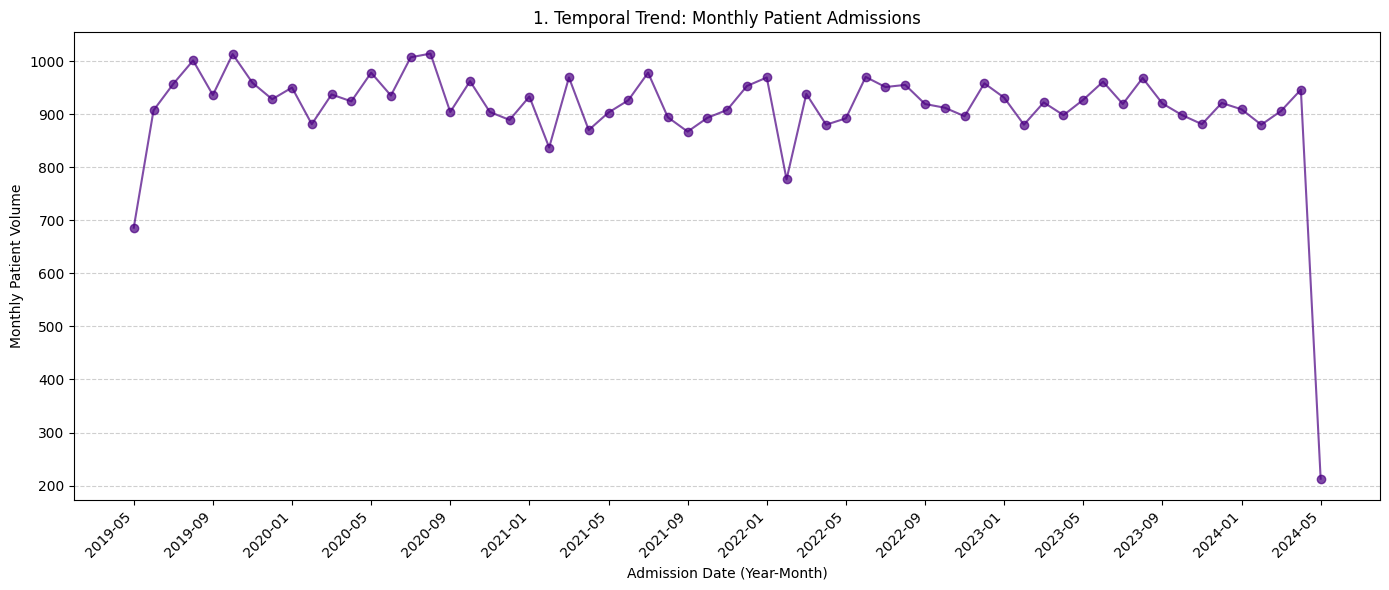

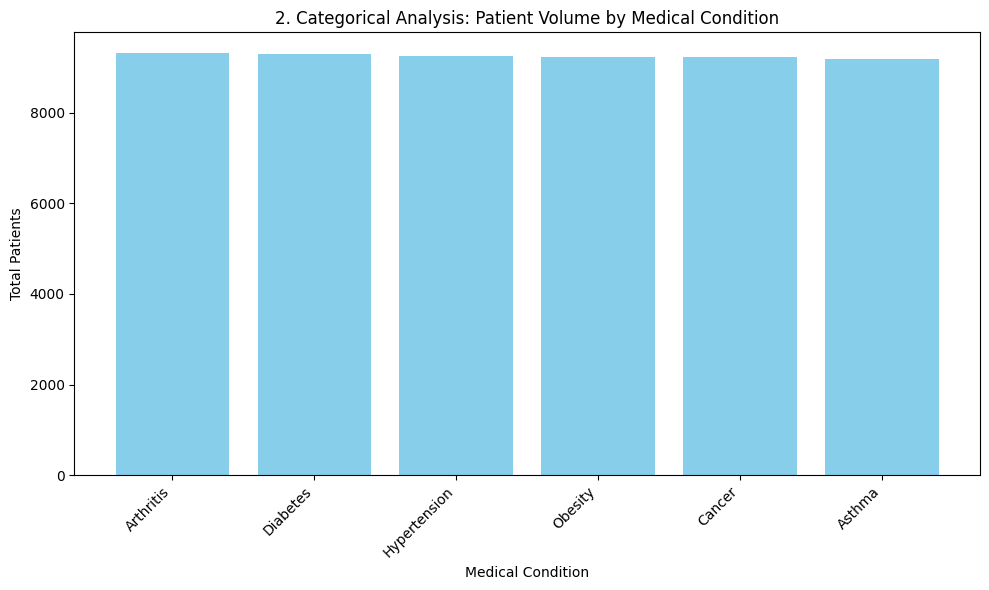

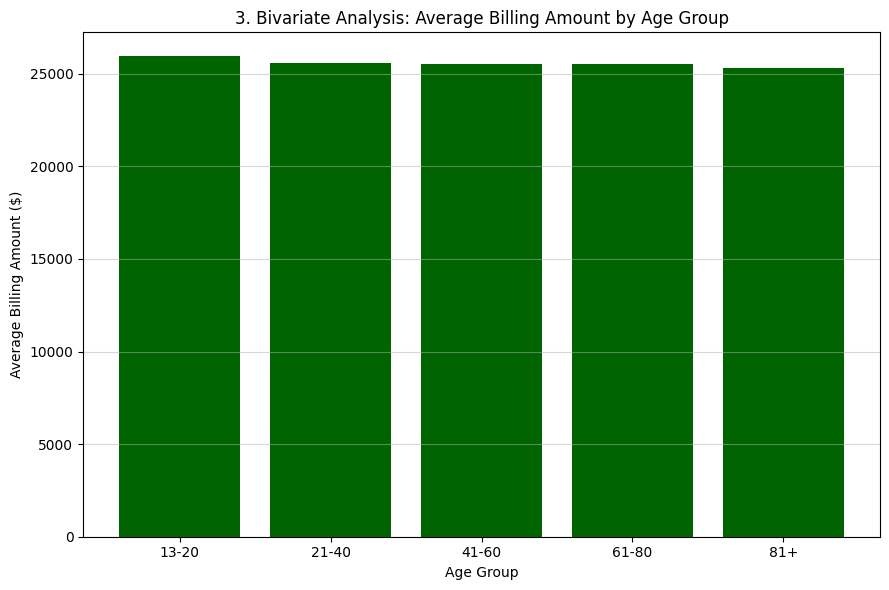

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, initcap, trim, datediff, to_date, 
    count, avg, when, date_format, round 
)
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1. SPARK SESSION SETUP & DATA LOADING =====
def setup_and_transform_data(file_path="healthcare_dataset.csv"):
    """Creates Spark session, loads data, and performs all cleaning/feature engineering."""
    # Initialize Spark Session
    spark = SparkSession.builder.appName("HealthcareAnalysis").master("local[*]").getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")

    # Load and clean data
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    # Standardize text columns
    text_cols = ['Name', 'Gender', 'Medical Condition', 'Doctor', 'Hospital', 
                 'Insurance Provider', 'Admission Type', 'Medication', 
                 'Test Results', 'Blood Type']
    for c in text_cols:
        df = df.withColumn(c, initcap(trim(col(c))))
        
    # Date conversion and Feature Engineering
    df = df.withColumn("Date of Admission", to_date(col("Date of Admission"), "yyyy-MM-dd"))
    df = df.withColumn("Discharge Date", to_date(col("Discharge Date"), "yyyy-MM-dd"))

    df = df.withColumn("Admission_Year_Month", date_format(col("Date of Admission"), "yyyy-MM"))
    df = df.withColumn("Age Group", 
        when((col("Age") >= 13) & (col("Age") <= 20), "13-20")
        .when((col("Age") >= 21) & (col("Age") <= 40), "21-40")
        .when((col("Age") >= 41) & (col("Age") <= 60), "41-60")
        .when((col("Age") >= 61) & (col("Age") <= 80), "61-80")
        .otherwise("81+")
    )
    return spark, df

# ===== 2. PYSPARK ANALYSIS FUNCTIONS =====
def temporal_analysis_spark(df):
    temporal_df = df.groupBy("Admission_Year_Month").agg(
        count(col("Name")).alias("Monthly Patient Volume")
    ).orderBy("Admission_Year_Month")
    return temporal_df

def categorical_analysis_spark(df):
    total_patients = df.count()
    condition_dist = df.groupBy("Medical Condition").agg(
        count("*").alias("Total Patients"),
    ).withColumn(
        "Share (%)", round(col("Total Patients") / total_patients * 100, 1)
    ).orderBy(col("Total Patients").desc())
    return condition_dist

def bivariate_analysis_spark(df):
    billing_by_age = df.groupBy("Age Group").agg(
        round(avg(col("Billing Amount")), 2).alias("Average Billing Amount ($)"),
    ).orderBy("Age Group")
    return billing_by_age

# ===== 3. VISUALIZATION AND DISPLAY FUNCTIONS =====
def create_visualizations_and_tables(temporal_pd, condition_pd, billing_pd):
    # --- Chart 1: Monthly Patient Volume Trend ---
    plt.figure(figsize=(14, 6))
    plt.plot(temporal_pd['Admission Period'], temporal_pd['Monthly Patient Volume'], marker='o', linestyle='-', color='indigo', alpha=0.7)
    n = 4 
    plt.xticks(temporal_pd['Admission Period'][::n], rotation=45, ha='right')
    plt.xlabel('Admission Date (Year-Month)')
    plt.ylabel('Monthly Patient Volume')
    plt.title('1. Temporal Trend: Monthly Patient Admissions')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('pyspark_monthly_patient_volume.png')

    # --- Chart 2: Medical Condition Distribution ---
    plt.figure(figsize=(10, 6))
    plt.bar(condition_pd['Medical Condition'], condition_pd['Total Patients'], color='skyblue')
    plt.xlabel('Medical Condition')
    plt.ylabel('Total Patients')
    plt.title('2. Categorical Analysis: Patient Volume by Medical Condition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('pyspark_condition_distribution.png')

    # --- Chart 3: Average Billing Amount by Age Group ---
    plt.figure(figsize=(9, 6))
    plt.bar(billing_pd['Age Group'], billing_pd['Average Billing Amount ($)'], color='darkgreen')
    plt.xlabel('Age Group')
    plt.ylabel('Average Billing Amount ($)')
    plt.title('3. Bivariate Analysis: Average Billing Amount by Age Group')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.savefig('pyspark_billing_by_age_group.png')

    # --- Print Tables ---
    print("\n" + "=" * 50)
    print("FINAL ANALYSIS TABLES")
    print("=" * 50)
    
    print("\n--- 1. Temporal Analysis: Monthly Patient Volume (Head 10) ---")
    print(temporal_pd.head(10).to_markdown(index=False, numalign="left", stralign="left")) 
    print("\n--- 2. Categorical Analysis: Medical Condition Distribution ---")
    print(condition_pd.to_markdown(index=False, numalign="left", stralign="left"))
    print("\n--- 3. Bivariate Analysis: Average Billing by Age Group ---")
    print(billing_pd.to_markdown(index=False, numalign="left", stralign="left"))
    print("=" * 50)


# ===== 4. MAIN EXECUTION =====
def main():
    spark, df_transformed = setup_and_transform_data()
    
    try:
        # Step 1: Run PySpark Analyses
        temporal_spark_df = temporal_analysis_spark(df_transformed)
        condition_spark_df = categorical_analysis_spark(df_transformed)
        billing_spark_df = bivariate_analysis_spark(df_transformed)
        
        # Step 2: Convert to Pandas for visualization and markdown display
        temporal_pd = temporal_spark_df.toPandas().rename(columns={'Admission_Year_Month': 'Admission Period'})
        condition_pd = condition_spark_df.toPandas()
        billing_pd = billing_spark_df.toPandas()
        
        # Step 3: Create Visualizations and Print Tables
        create_visualizations_and_tables(temporal_pd, condition_pd, billing_pd)
        
    except Exception as e:
        print(f"\nError during execution: {e}")
    
    finally:
        spark.stop()

if __name__ == "__main__":
    main()